In [4]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2


cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

In [5]:
using Plots
gr()  

Plots.GRBackend()

$ 0 = A_{c} k_{l} \frac{\partial^{2} T}{\partial \chi^{2}} + (T_{w,l} - T) h_{l} P$

$y = T_{w,l} - T$

$y'' = C^{2} y, C = sqrt(\frac{h_{l} P_{l}}{A_{c} k_{l}})$

$y = \tilde{c}_1 \cosh(C \chi) + \tilde{c}_2 \sinh(C \chi)$, hyperbolic functions， $ \chi \in (-C L_{l} / 2, C L_{l} / 2)$

$y(C L_{l} / 2) = y(-C L_{l} / 2)$

$\tilde{c}_2 = 0$

thus $y = \tilde{c}_1 \cosh(C \chi))$


heat rate balance
$ \frac{P L_{v} k_{l}}{\delta_{v}} (T_{v} - T_{w,v}) = \frac{P L_{v} k_{l}}{\delta_{v}} (T_{w,l} - T_{w,v} - \tilde{c}_1 \cosh(C L_{l} / 2))\\
= A_c k_l \frac{\partial T}{\partial \chi}(\chi = -L_{l} / 2) - A_c k_l \frac{\partial T}{\partial \chi}(\chi = L_{l} / 2) \\
=  A_c k_l (y'(C L_{l} / 2) - y'(-C L_{l} / 2)) \\
= 2\tilde{c}_1 A_c C \cosh(C L_{l} / 2)$

$\tilde{c}_1 = \frac{D(T_{w,l} - T_{w,v})}{D \cosh(C L_l/2) + 2C \sinh (C L_l/2)}$

$D = \frac{L_{v} P}{A_c \delta_{v}}$

# Properies

### Earth property

In [1521]:
g = 9.8

9.8

### Solid Physical parameters

In [1522]:
ρₛ = 2700; # density
cₛ  = 8.97e02; # specific heat
kₛ  = 1.67e02; # heat conductivity
# d = 2e-3;
plate_d = 2e-3;  # plate thickness
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.002)

### Fluid Physical parameters

In [1523]:
fluid_type = "butane"
Tᵥ = 291.0

291.0

In [1524]:
CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)

0.10768858457917865

In [1525]:
Cpₗ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",0.0,fluid_type)
ρₗ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",0.0,fluid_type)
μₗ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",0.0,fluid_type)
hₗ = CoolProp.PropsSI("H","T",Tᵥ,"Q",0.0,fluid_type)
kₗ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)
Prₗ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",0.0,fluid_type)

Cpᵥ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",1.0,fluid_type)
ρᵥ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)
μᵥ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",1.0,fluid_type);
hᵥ = CoolProp.PropsSI("H","T",Tᵥ,"Q",1.0,fluid_type)
kᵥ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",1.0,fluid_type)
Prᵥ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",1.0,fluid_type)

σ = CoolProp.PropsSI("I","T",Tᵥ,"Q",0.0,fluid_type)
P = CoolProp.PropsSI("P","T",Tᵥ,"Q",0.0,fluid_type)
R = CoolProp.PropsSI("GAS_CONSTANT","T",Tᵥ,"Q",1.0,fluid_type)
M = CoolProp.PropsSI("M","T",Tᵥ,"Q",1.0,fluid_type)
Rkg = R/M

# Cpₗ = Cpₗ*1e-4

αₗ = kₗ/ρₗ/Cpₗ
# αₗ = αₗ*1e4

νₗ = μₗ/ρₗ
νᵥ = μᵥ/ρᵥ;
hₗᵥ = hᵥ-hₗ;

# Plate Conduction

### Geometry parameters

In [1526]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [1527]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0005516330154011314, 0.001323919236962715)

### Set up the evaporator and condenser

In [1528]:
inch = 2.54e-2;

In [1529]:
power = 40 *0 #watts
total_heater_area = 2.0inch*2.0inch;

In [1530]:
qe = power/total_heater_area
hc = 1500.0 * 0
Tc = Tᵥ

291.0

In [1531]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((0.7inch,-0.0),0.0)
Tfe(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((-0.7inch,-0.0),0.0)
Tfe(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((-2.5inch,-0.0),0.0)
Tfc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((2.5inch,-0.0),0.0)
Tfc(cb2)

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

In [2203]:
ds = 1.5Δx
nturn = 16
width_ohp = 46.25*1e-3
length_ohp = 133.83*1e-3
gap = plate_d
pitch = width_ohp/(2*nturn+1)
x0, y0 = length_ohp/2, width_ohp/2

# x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
one_loop_gap = 1e-2
x, y, xf, yf = construct_oneloop_curve(0,0,ds,length_ohp,one_loop_gap,pi/2)


ohp = BasicBody(x,y)

Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


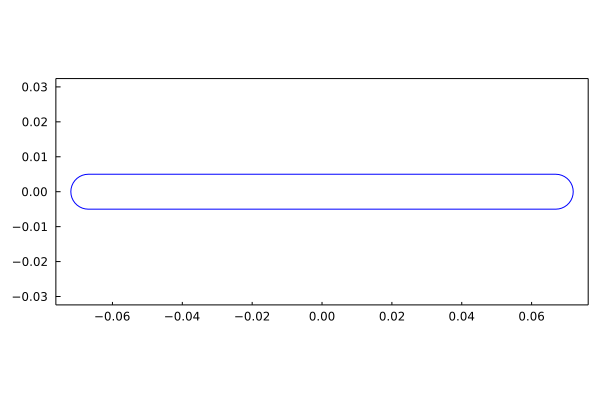

In [2204]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

In [2205]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{362,RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Create the system

In [2206]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


# OHP inner part

### Tube geometries

In [2207]:
tube_d = 1e-3; # tube diameter

peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
peri = Ac
# Ac = peri # tube cross-sectional area
L2D = length_ohp # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

true

In [2208]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,g,closedornot);

### Liquid

In [2209]:
Nu = 1.0
Hₗ = kₗ/tube_d * Nu # Nusselt number 4.36

107.68858457917865

In [2210]:
# X0,realratio = randomXp(L,numofslugs=60,chargeratio=0.45)
X0 = [(L2D/2,L/2+L2D/2)]

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r)

1-element Array{Tuple{Float64,Float64},1}:
 (0.0, 0.0)

In [2211]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tᵥ,L);

In [2212]:
liquids=Liquid(Hₗ,ρₗ,Cpₗ,αₗ,μₗ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [2213]:
δ

1-element Array{Float64,1}:
 0.001

In [2214]:
P = 0*zeros(length(X0)) .+ TtoP(Tᵥ);
δ = 0*zeros(length(X0)) .+ tube_d;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
vapors=Vapor(kₗ,P,δ);

### Wall

nucleate boiling sites

In [2215]:
ΔTthres = 100.0; # superheat threshold

    nucleatenum = 256
    Xstations = sort(rand(nucleatenum).*L);
#     Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

In [2216]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tᵥ);
θwallarray .= Tᵥ

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [2217]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [2218]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [2219]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [2220]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
# cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

# cbst = CallbackSet(cb_boiling,cb_merging);
cbst = CallbackSet(cb_boiling);

# combine inner tube and plate together

In [2221]:
tspan = (0.0, 50000.0);
dt_record = tspan[2] /20;

tstep=1e0

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [2222]:
ΔT = -1.0 #[K]

-1.0

In [2223]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
# Tplate = temperature(integrator_plate);
temperature(integrator_plate) .= Tᵥ;
temperature(integrator_plate)[1:139,:]  .=  Tᵥ + ΔT;

In [2224]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep, callback=cbst);

In [2225]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

currentsys.wall.θarray = temperature_linesource(integrator_plate)
currentsys = getcurrentsys(integrator_tube.u,currentsys)
integrator_tube.p = currentsys
qtmp = sys_to_heatflux(currentsys)
set_linesource_strength!(sys,qtmp);

In [2226]:
push!(plate_hist,deepcopy(integrator_plate)); 
push!(tube_hist,deepcopy(integrator_tube));

In [2279]:

@time for t in tspan[1]:tstep:tspan[2]
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t-tstep,integrator_plate.t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep);
    step!(integrator_tube,tstep,true);
    
    
      for j in 1:N_iter
        currentsys.wall.θarray = temperature_linesource(integrator_plate)
        currentsys = getcurrentsys(integrator_tube.u,currentsys)

        qtmp = sys_to_heatflux(currentsys)
        set_linesource_strength!(sys,qtmp)


#      ADI_timemarching!(temperature(integrator_plate),sys,tstep)
    end
    integrator_plate.t += tstep
    

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

52500.0
55000.0
57500.0
60000.0
62500.0
65000.0
67500.0
70000.0
72500.0
75000.0
77500.0
80000.0
82500.0
85000.0
87500.0
90000.0
92500.0
95000.0
97500.0
100000.0
207.647261 seconds (301.87 M allocations: 78.782 GiB, 17.02% gc time)


In [2281]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [2282]:
L

0.2993389261763431

In [2283]:
x .+ L/2

0.07483473154408578:0.001:0.22383473154408579

In [2284]:
sysfinal[end].liquid.θarrays[1]

181-element Array{Float64,1}:
 290.71012529302845
 290.69224833914313
 290.67461924711023
 290.65745656920984
 290.64074843890944
 290.62448330394693
 290.60864991834364
 290.5932373346295
 290.5782348962737
 290.5636322303172
 290.5494192402012
 290.5355860987863
 290.5221232415588
   ⋮
 290.5354573692473
 290.5492869730642
 290.56349633413447
 290.5780952770884
 290.5930938959106
 290.6085025609195
 290.6243319259365
 290.64059293565185
 290.65729683319216
 290.67445516789303
 290.69207980328406
 290.71012529302845

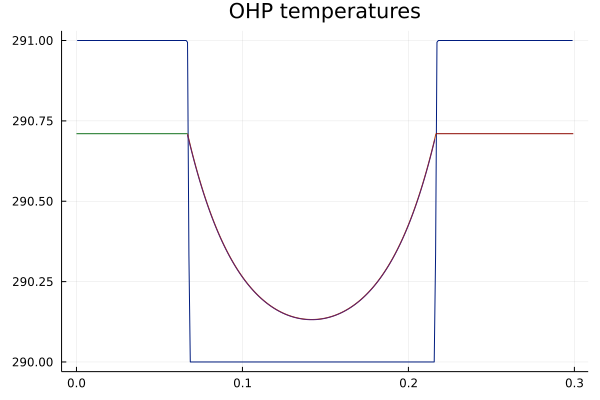

In [2289]:
# @gif for ii=1:length(sysfinal)
plot(sysfinal[end],plottype="T")
plot!(x .+ L2D .+ (L/2-L2D)/2,y)
# end

In [2286]:
aa = maximum(sysfinal[end].liquid.θarrays[1])

290.71012529302845

In [2287]:
bb = maximum(y)

290.70661611748744

In [2288]:
aa - bb

0.003509175541012155

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
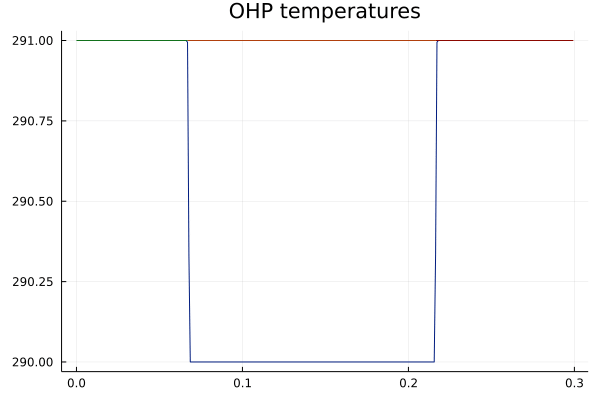

In [2236]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="T")
end

# plot the OHP

In [2237]:
q_tube_lines = sys_to_heatflux.(sysfinal);

In [2238]:
function add_qline(q_tube_lines)
    q_temp = zeros(length(q_tube_lines))
    for i = 1:length(q_tube_lines)
        q_temp[i] = sum(q_tube_lines[i] .* areas(sys.qline[1].body))
    end
    
    q_temp
end

add_qline (generic function with 1 method)

In [2239]:
q_tube_hist = add_qline(q_tube_lines);

In [2240]:
fact = 1.0/(ρₛ*cₛ*plate_d)

0.00020644948181180065

In [2241]:
q_plate = []
t_hist = []
for i=1:length(plate_hist)
    dT=deepcopy(plate_hist[i].p.qline[1].cache1);
    heatconduction_rhs!(dT,temperature(plate_hist[1]),plate_hist[i].p,0.0);
    push!(q_plate, dT ./ fact)
    push!(t_hist, plate_hist[i].t)
end

In [2242]:
q_plate_hist = cellsize(sys)^2 * sum.(q_plate);

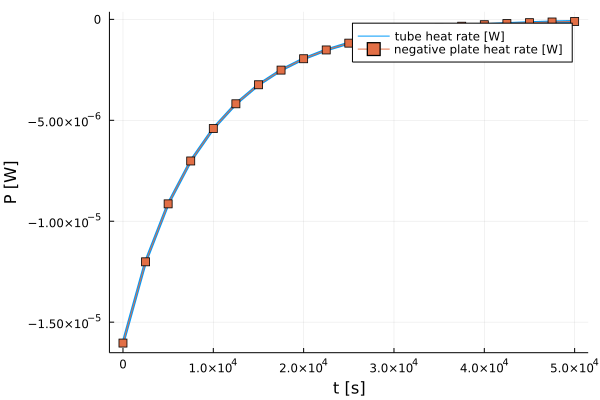

In [2243]:
plot(t_hist,q_tube_hist,linewidth=3.0,label="tube heat rate [W]")
plot!(t_hist,-q_plate_hist,ylabel="P [W]",xlabel="t [s]",markershape=:auto,label="negative plate heat rate [W]",legend=:topright)
# savefig("validation.pdf")

In [2244]:
norm((q_tube_hist+q_plate_hist) ./ q_tube_hist,Inf)

1.9467576437069482e-14

### Compare with analytical result at the beginning

In [2245]:
Lliquidslug = XptoLliquidslug(sys0.liquid.Xp,sys0.tube.L)

1-element Array{Float64,1}:
 0.14966946308817156

In [2246]:
Lvaporslug = XptoLvaporplug(sys0.liquid.Xp,sys0.tube.L,closedornot)

1-element Array{Float64,1}:
 0.14966946308817156

In [2247]:
Hᵥ=kₗ/δ[1]

107.68858457917865

In [2248]:
ΔT * (Hᵥ * peri * Lvaporslug[1] + Hₗ * peri * Lliquidslug[1])

-3.2235385269381636e-5

In [2249]:
Lᵥ = XptoLvaporplug(X0,L,true)[1]
Lₗ = XptoLliquidslug(X0,L)[1]

0.14966946308817156

In [2250]:
Hₗ/kₗ

1000.0

In [2251]:
peri/Ac

1.0

In [2252]:
k =sqrt(Hₗ*peri/(Ac*kₗ))

31.622776601683793

In [2253]:
cosh(2)

3.7621956910836314

In [2254]:
k*Lₗ/2

2.3664819976656037

In [2255]:
(D*cosh(k*Lₗ/2) + k*sinh(k*Lₗ/2))

971.7874849669001

In [2256]:
D

149.66550625969614

In [2257]:
D = peri * Lᵥ/ Ac / δ[1]
c_1 = D*ΔT/(D*cosh(k*Lₗ/2) + 2k*sinh(k*Lₗ/2))

-0.13141902423918947

In [2258]:
D*0.003

0.44900838926451464

In [2259]:
Tₕ = Tᵥ + ΔT

290.0

In [2260]:
x = -Lₗ/2:1e-3:Lₗ/2

y = Tₕ .- c_1 * cosh.(x .* k)

150-element Array{Float64,1}:
 290.70661611748744
 290.685010491502
 290.66408993309415
 290.6438335199621
 290.6242209940046
 290.60523274106123
 290.58684977129667
 290.56905370020917
 290.5518267302446
 290.5351516329974
 290.51901173198064
 290.50339088594825
 290.4882734727525
   ⋮
 290.49321557645385
 290.50849769564616
 290.5242883549104
 290.5406033462217
 290.55745898593096
 290.57487213108266
 290.592860196273
 290.61144117106636
 290.63063363798585
 290.6504567910979
 290.67093045520755
 290.6920751056852

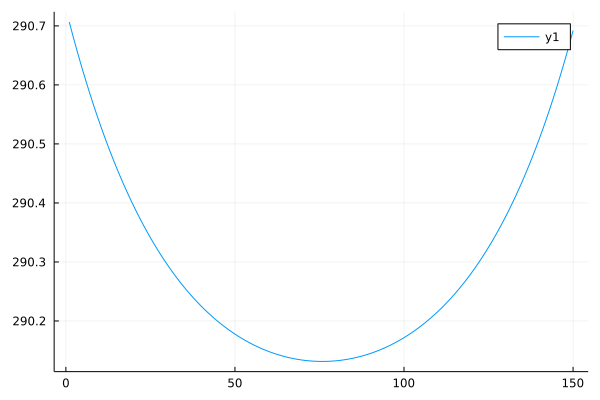

In [2261]:
plot(y)

In [2262]:
c_1*k*sinh(k*Lₗ/2)

-21.95530408719068

In [2263]:
D*(1 - c_1*cosh(k*Lₗ/2))

255.4283180019617

In [2264]:
Tb = PtoT(sysfinal[end].vapor.P)[1]

290.71153669439

In [2265]:
(Tb - Tᵥ) * Lᵥ * (kₗ/δ[1] *peri/hₗᵥ)

-1.2612999992027813e-11

In [2266]:
slope_r = getslope(sysfinal[end].liquid.θarrays[1][2],sysfinal[end].liquid.θarrays[1][1],sysfinal[end].liquid.Xarrays[1][2],sysfinal[end].liquid.Xarrays[1][1])

-21.39913147425174

In [2267]:
c_1*k*sinh(k*Lₗ/2)

-21.95530408719068

In [2268]:
real_slope_r = 

LoadError: [91msyntax: incomplete: premature end of input[39m

In [2269]:
sysfinal[end].liquid.θarrays[1][2],sysfinal[end].liquid.θarrays[1][1]

(290.69374352452814, 290.7115368385187)